In [36]:
%reset -f

In [37]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from skimage import io

In [38]:
c1 = pd.read_csv('IPQDA_23_ASS_D_DATA/tracked_Akt_KTR.csv', index_col='LABEL')
c2 = pd.read_csv('IPQDA_23_ASS_D_DATA/tracked_ERK_KTR.csv', index_col='LABEL')

In [39]:
c1 = c1.iloc[3:]
c2 = c2.iloc[3:]

In [40]:
c1.columns

Index(['ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y', 'POSITION_Z',
       'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY', 'MANUAL_SPOT_COLOR',
       'MEAN_INTENSITY_CH1', 'MEDIAN_INTENSITY_CH1', 'MIN_INTENSITY_CH1',
       'MAX_INTENSITY_CH1', 'TOTAL_INTENSITY_CH1', 'STD_INTENSITY_CH1',
       'CONTRAST_CH1', 'SNR_CH1'],
      dtype='object')

In [41]:
frame_counts = c1.groupby('TRACK_ID')['FRAME'].nunique()

# Check if any track has fewer than 27 frames
incomplete_tracks = frame_counts[frame_counts < 27]

# Print the incomplete tracks
print(incomplete_tracks)

TRACK_ID
1000    8
1001    9
1002    7
1003    8
1004    8
       ..
995     6
996     7
997     8
998     9
999     7
Name: FRAME, Length: 327, dtype: int64


In [42]:
df_bootstrap1 = c1.sample(n=len(c1), replace=True)
df_bootstrap2 = c2.sample(n=len(c1), replace=True)

In [43]:
df_median1 = df_bootstrap1.groupby(['TRACK_ID', 'FRAME'])['MEDIAN_INTENSITY_CH1'].median().reset_index()
df_median2 = df_bootstrap2.groupby(['TRACK_ID', 'FRAME'])['MEDIAN_INTENSITY_CH1'].median().reset_index()

In [44]:
df_median1['FRAME'] = df_median1['FRAME'].astype(int)
df_median1['steady_state_intensity'] = df_median1[df_median1['FRAME'] <= 6]['MEDIAN_INTENSITY_CH1'].median()
df_median1['normalized_intensity'] = df_median1['MEDIAN_INTENSITY_CH1'] / df_median1['steady_state_intensity']

df_median2['FRAME'] = df_median2['FRAME'].astype(int)
df_median2['steady_state_intensity'] = df_median2[df_median2['FRAME'] <= 6]['MEDIAN_INTENSITY_CH1'].median()
df_median2['normalized_intensity'] = df_median2['MEDIAN_INTENSITY_CH1'] / df_median2['steady_state_intensity']

In [45]:
df_global_median1 = df_median1.groupby('TRACK_ID')['normalized_intensity'].median().reset_index()
df_global_median2 = df_median2.groupby('TRACK_ID')['normalized_intensity'].median().reset_index()

## 3

In [46]:
# First, ensure the 'FRAME' column is numeric
df_median1['FRAME'] = df_median1['FRAME'].astype(int)
df_median2['FRAME'] = df_median2['FRAME'].astype(int)

In [47]:
# Calculate Global Steady State Intensity from the df_median DataFrame
global_steady_state_intensity1 = df_median1[df_median1['FRAME'] <= 6]['normalized_intensity'].median()
global_steady_state_intensity2 = df_median2[df_median2['FRAME'] <= 6]['normalized_intensity'].median()

In [48]:

# Calculate Minimal Intensity from the 7th time frame onwards
df_minimal1 = df_median1[df_median1['FRAME'] >= 7].groupby('TRACK_ID')['normalized_intensity'].min().reset_index()
df_minimal1.rename(columns={'normalized_intensity': 'minimal_intensity'}, inplace=True)

df_minimal2 = df_median2[df_median2['FRAME'] >= 7].groupby('TRACK_ID')['normalized_intensity'].min().reset_index()
df_minimal2.rename(columns={'normalized_intensity': 'minimal_intensity'}, inplace=True)

In [49]:

# Calculate the maximal change for each kinase
df_minimal1['maximal_change'] = (global_steady_state_intensity1 - df_minimal1['minimal_intensity']) / global_steady_state_intensity1
df_minimal2['maximal_change'] = (global_steady_state_intensity2 - df_minimal2['minimal_intensity']) / global_steady_state_intensity2

In [50]:

# Merge the minimal_intensity dataframe with df_global_median to get the time frame of minimal intensity
df_global_median1 = df_global_median1.merge(df_minimal1, on='TRACK_ID')
df_global_median2 = df_global_median2.merge(df_minimal2, on='TRACK_ID')

In [51]:
# First, create a new empty column for 'minimal_intensity_frame'
df_global_median1['minimal_intensity_frame'] = np.nan
df_global_median2['minimal_intensity_frame'] = np.nan

In [52]:

# Loop through each track in the df_global_median DataFrame
for i in df_global_median1.index:
    track_id = df_global_median1.loc[i, 'TRACK_ID']
    minimal_intensity = df_global_median1.loc[i, 'minimal_intensity']

    # Get the frame number where the minimal intensity was detected for this track
    minimal_intensity_frame = df_median1[(df_median1['TRACK_ID'] == track_id) &
                                        (df_median1['normalized_intensity'] == minimal_intensity)]['FRAME'].values[0]

    # Assign this frame number to the 'minimal_intensity_frame' column of df_global_median
    df_global_median1.loc[i, 'minimal_intensity_frame'] = minimal_intensity_frame

for i in df_global_median2.index:
    track_id = df_global_median2.loc[i, 'TRACK_ID']
    minimal_intensity = df_global_median2.loc[i, 'minimal_intensity']

    # Get the frame number where the minimal intensity was detected for this track
    minimal_intensity_frame = df_median2[(df_median2['TRACK_ID'] == track_id) &
                                        (df_median2['normalized_intensity'] == minimal_intensity)]['FRAME'].values[0]

    # Assign this frame number to the 'minimal_intensity_frame' column of df_global_median
    df_global_median2.loc[i, 'minimal_intensity_frame'] = minimal_intensity_frame

In [53]:
# Calculate the duration in minutes
# This calculation assumes that each frame represents 1 minute, adjust this as per your actual data
df_global_median1['duration'] = df_global_median1['minimal_intensity_frame'] - 7
df_global_median2['duration'] = df_global_median2['minimal_intensity_frame'] - 7

In [54]:
# Calculate the rate of maximal change
df_global_median1['rate_of_change'] = df_global_median1['maximal_change'] / df_global_median1['duration']
df_global_median2['rate_of_change'] = df_global_median2['maximal_change'] / df_global_median2['duration']

In [55]:
df_global_median1['KINASE'] = 'Akt'
df_global_median2['KINASE'] = 'ERK'
df_global_median = pd.concat([df_global_median1, df_global_median2])

In [56]:
overall_maximal_change = df_global_median.groupby(['KINASE', 'minimal_intensity_frame'])['maximal_change'].median().reset_index()
overall_rate_of_change = df_global_median.groupby(['KINASE', 'minimal_intensity_frame'])['rate_of_change'].median().reset_index()

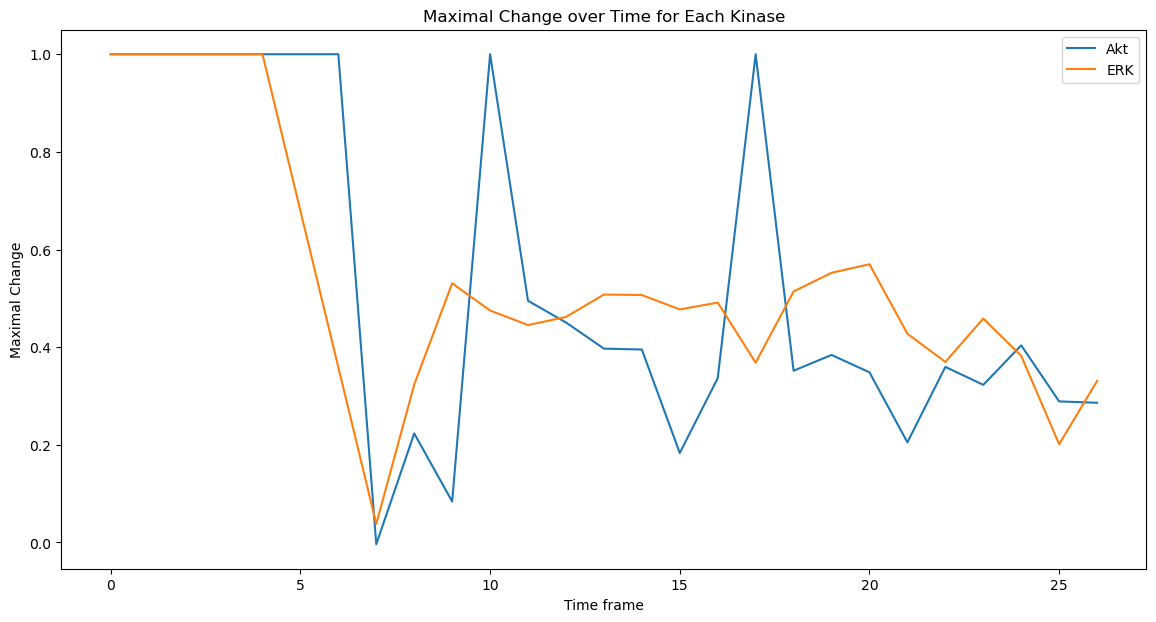

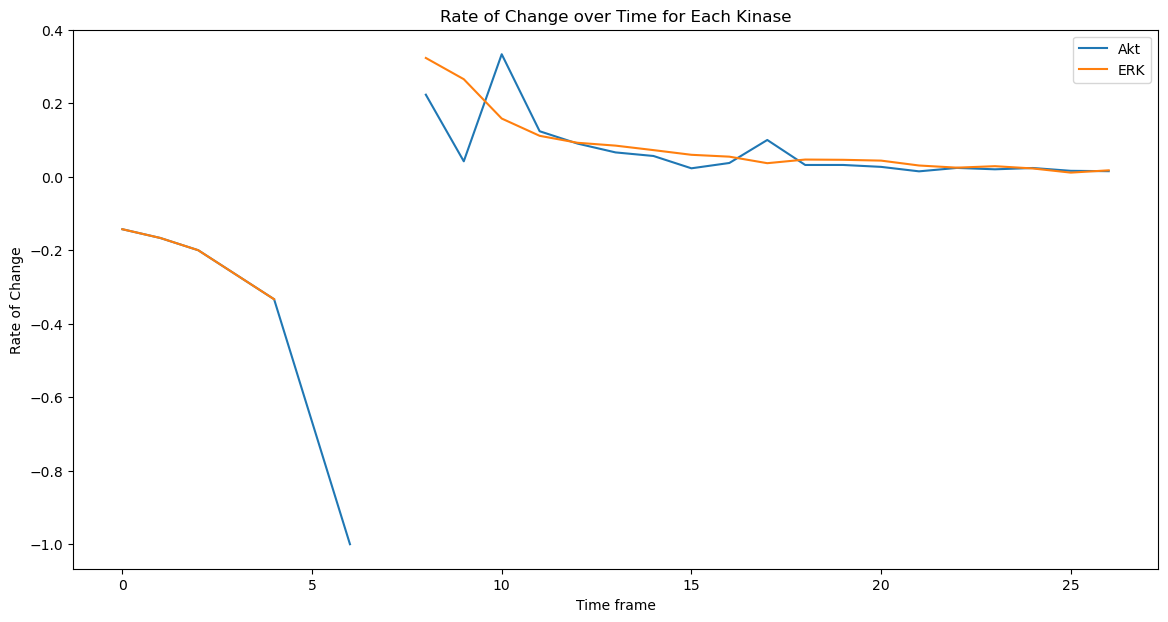

In [57]:
import matplotlib.pyplot as plt

# plot for maximal_change
plt.figure(figsize=(14, 7))
for kinase in overall_maximal_change['KINASE'].unique():
    plt.plot(overall_maximal_change[overall_maximal_change['KINASE'] == kinase]['minimal_intensity_frame'],
             overall_maximal_change[overall_maximal_change['KINASE'] == kinase]['maximal_change'], label=kinase)
plt.xlabel('Time frame')
plt.ylabel('Maximal Change')
plt.legend()
plt.title('Maximal Change over Time for Each Kinase')
plt.show()

# plot for rate_of_change
plt.figure(figsize=(14, 7))
for kinase in overall_rate_of_change['KINASE'].unique():
    plt.plot(overall_rate_of_change[overall_rate_of_change['KINASE'] == kinase]['minimal_intensity_frame'],
             overall_rate_of_change[overall_rate_of_change['KINASE'] == kinase]['rate_of_change'], label=kinase)
plt.xlabel('Time frame')
plt.ylabel('Rate of Change')
plt.legend()
plt.title('Rate of Change over Time for Each Kinase')
plt.show()